In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mm = load_model('/content/drive/MyDrive/ProjectML-@LAS/resnet50_similarity_model_full.h5')

In [ ]:
BASE_DIR = '/content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images'

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_EVAL_DIR = os.path.join(BASE_DIR, 'test', 'test_')

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001

print(f"Directory สำหรับ Training: {TRAIN_DIR}")
print(f"Directory สำหรับ Testing/Evaluation: {TEST_EVAL_DIR}")

Directory สำหรับ Training: /content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images/train
Directory สำหรับ Testing/Evaluation: /content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images/test/test_


In [ ]:
# @title 3.1 ข้ามไฟล์รูปที่เสียหาย
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2871 images belonging to 18 classes.


In [ ]:
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 761 images belonging to 18 classes.


In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    TEST_EVAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 18 images belonging to 18 classes.


In [ ]:
NUM_CLASSES = train_generator.num_classes
print(f"จำนวนคลาสทั้งหมด: {NUM_CLASSES}")
print(f"ชื่อคลาส: {train_generator.class_indices}")

จำนวนคลาสทั้งหมด: 18
ชื่อคลาส: {'Antarctica': 0, 'Burj Khalifa - UAE': 1, 'Chich-n Itz - Mexico': 2, 'Christ the Reedemer Statue': 3, 'Eiffel Tower - Paris': 4, 'Giant-s Causeway': 5, 'Great Wall Of China - China': 6, 'Himalaya - India': 7, 'Machu Pichu': 8, 'Niagara Falls': 9, 'Pyramids Of Giza - Egypt': 10, 'Roman Colosseum - Rome': 11, 'Santorini': 12, 'Statue Of Liberty - NYC': 13, 'Stonehenge': 14, 'Taj Mahal - India': 15, 'The Blue Grotto - Capri': 16, 'Venezuela Angel Falls': 17}


In [ ]:
base_model = ResNet50V2(
    weights='imagenet',   # ใช้ Weights ที่เทรนแล้ว
    include_top=False,   # ไม่รวม Layer Output เดิม
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax') # 18 node outputs สำหรับ 18 คลาส
])

In [ ]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(18, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model.save("model_retrieval.keras")

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('my_retrieval_model_final_atlas.h5', compile=False)
model.summary()

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_csrossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,623,122 (93.93 MB)

 Trainable params: 1,058,322 (4.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

final_val_acc = history.history['val_accuracy'][-1]
print(f"\nValidation Accuracy สุดท้าย: {final_val_acc:.4f}")

In [ ]:
test_generator.reset()

loss, accuracy = model.evaluate(test_generator,
                                steps=test_generator.samples // BATCH_SIZE + 1,
                                verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [ ]:
model.save('/content/drive/MyDrive/ProjectML-@LAS/resnet50_similarity_model_full.h5', include_optimizer=False)

In [ ]:
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = tf.argmax(predictions, axis=1)

true_classes = test_generator.classes
label_map = {v: k for k, v in train_generator.class_indices.items()}

for i in range(10):
    predicted_label = label_map[predicted_classes.numpy()[i]]
    true_label = label_map[true_classes[i]]
    result = "ถูกต้อง" if predicted_classes.numpy()[i] == true_classes[i] else "ผิด"
    print(f"ไฟล์: {test_generator.filenames[i]} ------ predict: {predicted_label} ----|---- actual: {true_label} ({result})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
ไฟล์: Antarctica/5.jpg ------ predict: Venezuela Angel Falls ----|---- actual: Antarctica (ผิด)
ไฟล์: Burj Khalifa - UAE/9.jpg ------ predict: Christ the Reedemer Statue ----|---- actual: Burj Khalifa - UAE (ผิด)
ไฟล์: Chich-n Itz - Mexico/2.AtractivoGrande_2352019081130.jpg ------ predict: Taj Mahal - India ----|---- actual: Chich-n Itz - Mexico (ผิด)
ไฟล์: Christ the Redeemer Statue/90.jpg ------ predict: The Blue Grotto - Capri ----|---- actual: Christ the Reedemer Statue (ผิด)
ไฟล์: Eiffel Tower - Paris/60.01-eiffel-tower.jpg ------ predict: The Blue Grotto - Capri ----|---- actual: Eiffel Tower - Paris (ผิด)
ไฟล์: Giant-s Causeway/37.831300.jpg ------ predict: Venezuela Angel Falls ----|---- actual: Giant-s Causeway (ผิด)
ไฟล์: Great Wall of China - China/43.great-wall-of-china-facts-2.jpg ------ predict: Eiffel Tower - Paris ----|---- actual: Great Wall Of China - China (ผิด)
ไฟล์: Himalaya - India/63.hangchendzonga-national-par.jpg ------ pred

In [ ]:
SINGLE_IMAGE_PATH = '/content/img.jpg'

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

IMAGE_SIZE = (224, 224)
try:
    img = image.load_img(SINGLE_IMAGE_PATH, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)

    predicted_class_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    label_map = {v: k for k, v in train_generator.class_indices.items()}
    predicted_label = label_map[predicted_class_index]

    print(f"โมเดลทำนายว่าเป็นสถานที่: {predicted_label}")
    print(f"ด้วยความมั่นใจ: {confidence * 100:.2f}%")

except FileNotFoundError:
    print(f"ไม่พบไฟล์รูปภาพที่ Path: {SINGLE_IMAGE_PATH}")
except NameError:
    print("ตัวแปร 'model' หรือ 'train_generator' ไม่ถูกกำหนด กรุณารัน Cell 4 และ Cell 3 อีกครั้ง")
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการประมวลผลรูปภาพ: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
โมเดลทำนายว่าเป็นสถานที่: Christ the Reedemer Statue
ด้วยความมั่นใจ: 36.46%


In [ ]:
from tensorflow.keras.models import Sequential
import numpy as np

feature_extractor = Sequential(model.layers[:-2])
feature_extractor.build((None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [ ]:
import os
from tqdm.notebook import tqdm
import numpy as np

train_generator.reset()
all_features = []
all_paths = []

num_steps = train_generator.samples // BATCH_SIZE + 1

for i in tqdm(range(num_steps), desc="Building DB"):
    x, y = next(train_generator)
    features = feature_extractor.predict_on_batch(x)
    all_features.append(features)

    current_index = i * BATCH_SIZE
    current_paths = [os.path.join(train_generator.directory, path) for path in train_generator.filenames[current_index : current_index + len(x)]]
    all_paths.extend(current_paths)

all_features = np.concatenate(all_features)
print(f"\nฐานข้อมูล Feature: {all_features.shape[0]}")

Building DB:   0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
np.save('/content/drive/MyDrive/ProjectML-@LAS/features.npy', all_features)
np.save('/content/drive/MyDrive/ProjectML-@LAS/paths.npy', all_paths)

In [ ]:
from scipy.spatial.distance import cdist
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

def predict_and_find_similar(input_path, num_results=5):

    img = image.load_img(input_path, target_size=IMAGE_SIZE)
    img_prepped = np.expand_dims(image.img_to_array(img), axis=0) / 255.0

    # 1. ทำนายคลาส
    predictions_proba = model.predict(img_prepped, verbose=0)
    predicted_class_index = np.argmax(predictions_proba[0])
    label_map = {v: k for k, v in train_generator.class_indices.items()}
    predicted_label = label_map[predicted_class_index]
    confidence = np.max(predictions_proba[0])
    print(f"Predict: {predicted_label} Confidence: {confidence * 100:.2f}%")

    # 2. กรองฐานข้อมูล Features
    all_classes_from_path = [os.path.basename(os.path.dirname(p)) for p in all_paths]
    filtered_indices = [i for i, c in enumerate(all_classes_from_path) if c == predicted_label]
    filtered_features = all_features[filtered_indices]
    filtered_paths = [all_paths[i] for i in filtered_indices]

    # 3. ค้นหาความคล้ายคลึง
    input_feature = feature_extractor.predict_on_batch(img_prepped)
    distances = cdist(input_feature, filtered_features, metric='euclidean')[0] # <--- เปลี่ยนเป็น Euclidean

    similar_indices = np.argsort(distances)[:num_results]
    final_results = [(filtered_paths[i], distances[i]) for i in similar_indices]


    num_columns = num_results + 1 # 1 Query + 5 Results = 6 ช่อง

    plt.figure(figsize=(18, 6))

    # แสดงรูป Query (ช่องที่ 1)
    plt.subplot(1, num_columns, 1)
    plt.imshow(img)
    plt.title(f"1. Query (TEST)\n{predicted_label}")
    plt.axis('off')

    # แสดงผลการค้นหา 5 อันดับแรก (ช่องที่ 2 - 6)
    for i, (path, dist) in enumerate(final_results):
        plt.subplot(1, num_columns, i + 2) # เริ่มจากตำแหน่งที่ 2
        sim_img = Image.open(path)

        source_folder = "TRAIN/VAL"
        if "test" in path.lower():
             source_folder = "TEST"

        plt.imshow(sim_img)
        plt.title(f"Rank {i+1} ({source_folder})\nDist: {dist:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import json

class_indices = train_generator.class_indices
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

In [ ]:
# @title 8.1 ทดสอบจาก test
INDEX_TO_TEST = 9
test_generator.reset()
try:
    file_name_to_test = test_generator.filenames[INDEX_TO_TEST]
    test_sample_path = os.path.join(TEST_EVAL_DIR, file_name_to_test)
    predict_and_find_similar(test_sample_path, num_results=5)
except Exception as e:
    print(f"{e}")

Predict: Venezuela Angel Falls Confidence: 48.21%
list indices must be integers or slices, not list


In [ ]:
MY_UPLOADED_IMAGE_PATH = '/content/img.jpg'

In [ ]:
# @title 8.2 ทดสอบจากรูป upload
if os.path.exists(MY_UPLOADED_IMAGE_PATH):
    predict_and_find_similar(MY_UPLOADED_IMAGE_PATH, num_results=5)
else:
    print(f"\nไม่พบไฟล์ {MY_UPLOADED_IMAGE_PATH}")

Predict: Christ the Reedemer Statue Confidence: 21.50%


TypeError: list indices must be integers or slices, not list

In [ ]:
import os

SAVE_DIR = '/content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images'
MODEL_FILENAME = 'my_retrieval_model_final_atlas.h5'
FULL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)

model.save(FULL_SAVE_PATH)

print(f"บันทึกโมเดลสำเร็จที่: {FULL_SAVE_PATH}")

บันทึกโมเดลสำเร็จที่: /content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images/my_retrieval_model_final_atlas.h5


In [ ]:
import numpy as np
import os
SAVE_DIR = '/content/drive/MyDrive/ProjectML-@LAS/'
np.save(os.path.join(SAVE_DIR, 'all_features.npy'), all_features)

In [ ]:
import numpy as np
import os
SAVE_DIR = '/content/drive/MyDrive/ProjectML-@LAS/'
np.save(os.path.join(SAVE_DIR, 'all_paths.npy'), all_paths, allow_pickle=True)

In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/ProjectML-@LAS/my_retrieval_model_final_atlas.keras'
model.save(MODEL_SAVE_PATH)
print(f"บันทึกโมเดลใหม่สำเร็จที่: {MODEL_SAVE_PATH}")

In [ ]:
base_model_to_save = model.layers[0]

WEIGHTS_SAVE_PATH = '/content/drive/MyDrive/ProjectML-@LAS/resnet_weights.weights.h5'
base_model_to_save.save_weights(WEIGHTS_SAVE_PATH)

print(f"บันทึกไฟล์น้ำหนักสำเร็จที่: {WEIGHTS_SAVE_PATH}")

In [ ]:
import numpy as np

raw_weights = model.layers[0].get_weights()

WEIGHTS_SAVE_PATH = '/content/drive/MyDrive/ProjectML-@LAS/resnet_raw_weights_fixed.npy' # เปลี่ยนชื่อไฟล์

np.save(WEIGHTS_SAVE_PATH, np.array(raw_weights, dtype=object), allow_pickle=True)

print(f"บันทึกไฟล์น้ำหนักดิบสำเร็จที่: {WEIGHTS_SAVE_PATH}")

In [ ]:
import json

class_indices = train_generator.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)
print("บันทึก class_indices.json เรียบร้อย")

In [ ]:
import numpy as np
import json
import os
# ตัวแปรเหล่านี้ควรจะพร้อมใช้งานแล้ว: model, train_generator, all_features, all_paths

# 1. บันทึก Model
model.save('my_model.h5')
print("✅ 1. บันทึก my_model.h5 เรียบร้อย")

# 2. บันทึก Label Map (จำเป็นสำหรับ Streamlit)
class_indices = train_generator.class_indices
# บันทึกเป็น Class Name (string) : Index (int)
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)
print("✅ 2. บันทึก class_indices.json เรียบร้อย")

# 3. บันทึกฐานข้อมูล Features
np.save('all_features.npy', all_features)
print(f"✅ 3. บันทึก all_features.npy เรียบร้อย ({all_features.shape})")

# 4. บันทึก Paths พร้อมแก้ไขให้เป็น Placeholder (สำคัญมาก!)
# BASE_DIR ในโค้ดคุณคือ: /content/drive/MyDrive/ProjectML-@LAS/Google Images
# เราจะแทนที่ส่วนของ Google Drive ด้วย PLACEHOLDER_PREFIX/

# ใช้ BASE_DIR ที่คุณกำหนดไว้ในโค้ดต้นฉบับ
# ตัวอย่างเช่น /content/drive/MyDrive/ProjectML-@LAS
drive_path_prefix_to_remove = os.path.dirname(BASE_DIR)

paths_for_app = []

for p in all_paths:
    # เปลี่ยน Path ใน Drive เป็น Placeholder
    # เช่น /content/drive/MyDrive/ProjectML-@LAS/Google Images/train/ClassX/img.jpg
    # จะกลายเป็น PLACEHOLDER_PREFIX/Google Images/train/ClassX/img.jpg
    p_relative = p.replace(drive_path_prefix_to_remove, 'PLACEHOLDER_PREFIX')
    paths_for_app.append(p_relative)

with open('all_paths.txt', 'w') as f:
    for item in paths_for_app:
        f.write("%s\n" % item)

print("✅ 4. บันทึก all_paths.txt เรียบร้อย (ใช้ Placeholder)")

In [ ]:
# โค้ดสำหรับบันทึกโมเดลใหม่ใน Colab
# ------------------------------------
# 1. บังคับให้ใช้ Keras API โดยตรง
import keras
from tensorflow.keras.models import load_model

# 2. บันทึกโมเดลด้วย save_format='h5'
# นี่เป็นวิธีที่เข้ากันได้ง่ายที่สุด
# โดยให้ชื่อไฟล์ใหม่เป็น 'my_model_v2.h5'
model.save('my_model_v2.h5', save_format='h5')

print("บันทึกโมเดลใหม่สำเร็จในชื่อ my_model_v2.h5")

# รันโค้ดบันทึกไฟล์ .npy และ .json อื่นๆ ด้วย
# ... (โค้ดบันทึก all_features.npy, all_paths.txt, class_indices.json)
# ------------------------------------

In [ ]:
# โค้ดสำหรับบันทึกโมเดลใน Colab (สำหรับ Keras 3 โดยเฉพาะ)
# ----------------------------------------------------------------------
import tensorflow as tf
import keras
import os
import shutil # สำหรับลบโฟลเดอร์ชั่วคราว

# 1. กำหนดชื่อไฟล์ใหม่ (ใช้ .keras นามสกุลใหม่ที่ดีที่สุด)
# นี่คือรูปแบบที่ Keras 3 แนะนำและยืดหยุ่นกว่า .h5
final_keras_path = 'final_working_model.keras'

# 2. บันทึกโมเดลโดยตรง (Keras 3 จะใช้รูปแบบ .keras อัตโนมัติ)
# ถ้าโมเดลเคยถูกบันทึกมาแล้ว ควรลบออกก่อน
if os.path.exists(final_keras_path):
    os.remove(final_keras_path)

model.save(final_keras_path)

print(f"บันทึกโมเดลที่เข้ากันได้สำเร็จในชื่อ: {final_keras_path}")

# 3. ลบโฟลเดอร์ชั่วคราว (ถ้ามี)
if os.path.isdir('temp_model_tf'):
    shutil.rmtree('temp_model_tf')

# 4. รันโค้ดบันทึกไฟล์ .npy และ .json อื่นๆ ด้วย
# ... (คุณต้องมั่นใจว่าโค้ดบันทึก all_features.npy, all_paths.txt, class_indices.json อยู่ใน Cell นี้หรือรันไปแล้ว)
# ----------------------------------------------------------------------

In [ ]:
# เพิ่มโค้ดนี้ใน Colab ต่อจากเซลล์ที่เทรนเสร็จแล้ว

# 1. บันทึกโมเดลหลัก
model.save('my_image_classifier_model.h5') # หรือ .keras
print("บันทึกโมเดลหลักแล้ว")

# 2. บันทึกตัวสกัดคุณลักษณะ (Feature Extractor)
feature_extractor.save('my_feature_extractor_model.h5')
print("บันทึก Feature Extractor แล้ว")

# 3. บันทึกฐานข้อมูล Features และ Paths
import numpy as np
import pickle

np.save('all_features.npy', all_features)
with open('all_paths.pkl', 'wb') as f:
    pickle.dump(all_paths, f)
print("บันทึกฐานข้อมูล Features และ Paths แล้ว")

# 4. บันทึก Label Map
import json
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)
print("บันทึก Class Indices แล้ว")

In [ ]:
from tensorflow.keras.models import load_model

SAVE_DIR = '/content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS'
MODEL_FILENAME = 'my_retrieval_model_final_atlas.h5'
FULL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)

model = load_model(FULL_SAVE_PATH)
print("โหลดโมเดลสำเร็จ ✅")

โหลดโมเดลสำเร็จ ✅


In [ ]:
SAVE_DIR = '/content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS'
MODEL_PATH = os.path.join(SAVE_DIR, 'my_retrieval_model_final_atlas.h5')

model = load_model(MODEL_PATH)
model.summary()
# all_features = np.load(os.path.join(SAVE_DIR, 'all_features.npy'))
# all_paths = np.load(os.path.join(SAVE_DIR, 'all_paths.npy'), allow_pickle=True)

# print(f"all_features shape: {all_features.shape}")
# print(f"จำนวน path: {len(all_paths)}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,623,124 (93.93 MB)

 Trainable params: 1,058,322 (4.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
IMAGE_SIZE = (224, 224)
feature_extractor = Sequential(model.layers[:-2])
feature_extractor.build((None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [ ]:
def predict_and_find_similar(input_path, num_results=5):
    # เตรียมภาพ input
    img = image.load_img(input_path, target_size=IMAGE_SIZE)
    img_prepped = np.expand_dims(image.img_to_array(img), axis=0) / 255.0

    # 1. ทำนายคลาส
    predictions_proba = model.predict(img_prepped, verbose=0)
    predicted_class_index = np.argmax(predictions_proba[0])
    confidence = np.max(predictions_proba[0])
    print(f"Predict class index: {predicted_class_index}, Confidence: {confidence * 100:.2f}%")

    # 2. คำนวณ feature ของภาพ input
    input_feature = feature_extractor.predict_on_batch(img_prepped)

    # 3. คำนวณระยะทาง Euclidean กับฐานข้อมูลทั้งหมด
    distances = cdist(input_feature, all_features, metric='euclidean')[0]
    similar_indices = np.argsort(distances)[:num_results]

    # 4. แสดงภาพผลลัพธ์
    plt.figure(figsize=(18, 6))
    plt.subplot(1, num_results + 1, 1)
    plt.imshow(img)
    plt.title("Query Image")
    plt.axis('off')

    for i, idx in enumerate(similar_indices):
        sim_img = Image.open(all_paths[idx])
        plt.subplot(1, num_results + 1, i + 2)
        plt.imshow(sim_img)
        plt.title(f"Rank {i+1}\nDist: {distances[idx]:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from scipy.spatial.distance import cdist

def predict_and_find_similar(input_path, num_results=5):
    # --- ตรวจสอบไฟล์ input ---
    if not os.path.exists(input_path):
        print(f"❌ ไม่พบไฟล์รูปภาพ: {input_path}")
        return

    # --- เตรียมภาพ input ---
    img = image.load_img(input_path, target_size=IMAGE_SIZE)
    img_prepped = np.expand_dims(image.img_to_array(img), axis=0) / 255.0

    # --- 1. ทำนายคลาส ---
    predictions_proba = model.predict(img_prepped, verbose=0)
    predicted_class_index = np.argmax(predictions_proba[0])
    confidence = np.max(predictions_proba[0])
    print(f"✅ Predict class index: {predicted_class_index}, Confidence: {confidence * 100:.2f}%")

    # --- 2. คำนวณ feature ของภาพ input ---
    input_feature = feature_extractor.predict_on_batch(img_prepped)

    # --- 3. คำนวณระยะทาง Euclidean กับฐานข้อมูลทั้งหมด ---
    distances = cdist(input_feature, all_features, metric='euclidean')[0]
    similar_indices = np.argsort(distances)[:num_results]

    # --- 4. แสดงภาพผลลัพธ์ ---
    plt.figure(figsize=(18, 6))
    plt.subplot(1, num_results + 1, 1)
    plt.imshow(img)
    plt.title("Query Image")
    plt.axis('off')

    shown = 0
    for idx in similar_indices:
        path = str(all_paths[idx])  # แปลงให้เป็น string ปกติ
        if not os.path.exists(path):
            print(f"⚠️ ไม่พบไฟล์: {path}")
            continue

        try:
            sim_img = Image.open(path)
        except Exception as e:
            print(f"⚠️ เปิดไฟล์ไม่ได้: {path} ({e})")
            continue

        shown += 1
        plt.subplot(1, num_results + 1, shown + 1)
        plt.imshow(sim_img)
        plt.title(f"Rank {shown}\nDist: {distances[idx]:.4f}")
        plt.axis('off')

        if shown >= num_results:
            break

    if shown == 0:
        print("❌ ไม่มีไฟล์ที่สามารถแสดงได้เลย")
    else:
        plt.tight_layout()
        plt.show()


### ***The Last Of Process Project***

Mounted at /content/drive
✅ Feature extractor ready! Output shape: (None, 2048)
Found 2871 images belonging to 18 classes.

📂 Processing folder: /content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images/train


train: 0it [00:00, ?it/s]
Burj Khalifa - UAE: 100%|██████████| 134/134 [00:22<00:00,  5.84it/s]



📂 Processing folder: /content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images/val


val: 0it [00:00, ?it/s]
Chich-n Itz - Mexico: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]



📂 Processing folder: /content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images/test/test_


test_: 0it [00:00, ?it/s]
Burj Khalifa - UAE: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]



✅ Features database rebuilt successfully!
Total: 3650 images | Shape: (3650, 2048)
📦 Loaded feature DB: (3650, 2048)
🔍 Predict: Pyramids Of Giza - Egypt | Confidence: 96.29%


Distances (batches): 100%|██████████| 2/2 [00:00<00:00, 665.71it/s]


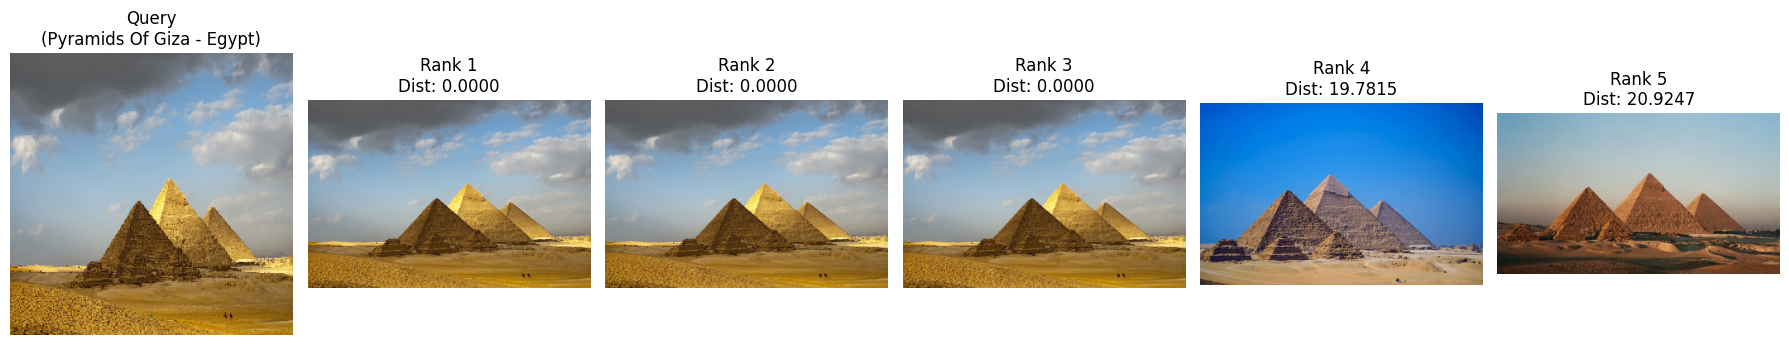

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from google.colab import drive
from tqdm import tqdm

drive.mount('/content/drive', force_remount=True)

SAVE_DIR = '/content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/'
MODEL_PATH = os.path.join(SAVE_DIR, 'my_retrieval_model_final_atlas.h5')
BASE_DIR = os.path.join(SAVE_DIR, 'Google Images')

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test', 'test_')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
ImageFile.LOAD_TRUNCATED_IMAGES = True

model = load_model(MODEL_PATH, compile=False)

target_layer_name = None
for layer in model.layers:
    if "global_average_pooling" in layer.name:
        target_layer_name = layer.name
        break

if target_layer_name is None:
    raise ValueError("❌ ไม่พบเลเยอร์ global_average_pooling ในโมเดล")

inp = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = inp
for layer in model.layers:
    x = layer(x)
    if layer.name == target_layer_name:
        break
feature_extractor = Model(inputs=inp, outputs=x)
print("✅ Feature extractor ready! Output shape:", feature_extractor.output_shape)

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
label_map = {v: k for k, v in train_generator.class_indices.items()}

def build_feature_database(base_dirs, output_dir):
    all_features, all_paths = [], []

    for base_dir in base_dirs:
        print(f"\n📂 Processing folder: {base_dir}")
        for root, _, files in os.walk(base_dir):
            for file in tqdm(files, desc=os.path.basename(root)):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(root, file)
                    try:
                        img = load_img(img_path, target_size=IMAGE_SIZE)
                        img_array = np.expand_dims(img_to_array(img), axis=0)
                        img_array = preprocess_input(img_array)
                        feature = feature_extractor.predict(img_array, verbose=0)
                        all_features.append(feature.flatten())
                        all_paths.append(img_path)
                    except Exception as e:
                        print(f"⚠️ Skip: {img_path} ({e})")

    np.save(os.path.join(output_dir, 'all_features.npy'), np.array(all_features))
    np.save(os.path.join(output_dir, 'all_paths.npy'), np.array(all_paths))
    print("\n✅ Features database rebuilt successfully!")
    print(f"Total: {len(all_paths)} images | Shape: {np.array(all_features).shape}")

# 🧩 ถ้าต้องการสร้างใหม่ ให้ uncomment
build_feature_database([TRAIN_DIR, VAL_DIR, TEST_DIR], SAVE_DIR)

all_features = np.load(os.path.join(SAVE_DIR, 'all_features.npy'))
all_paths = np.load(os.path.join(SAVE_DIR, 'all_paths.npy'), allow_pickle=True)
print("📦 Loaded feature DB:", all_features.shape)

def predict_and_find_similar(input_path, num_results=5, batch_size=128):
    img = load_img(input_path, target_size=IMAGE_SIZE)
    img_prepped = np.expand_dims(img_to_array(img), axis=0)
    img_prepped = preprocess_input(img_prepped)

    predictions_proba = model.predict(img_prepped, verbose=0)
    predicted_class_index = np.argmax(predictions_proba[0])
    predicted_label = label_map[predicted_class_index]
    confidence = np.max(predictions_proba[0])
    print(f"🔍 Predict: {predicted_label} | Confidence: {confidence * 100:.2f}%")

    all_classes_from_path = [os.path.basename(os.path.dirname(p)) for p in all_paths]
    filtered_indices = [i for i, c in enumerate(all_classes_from_path) if c == predicted_label]
    filtered_features = all_features[filtered_indices]
    filtered_paths = [str(all_paths[i]) for i in filtered_indices]

    query_feature_full = feature_extractor.predict(img_prepped, verbose=0).flatten()

    input_feature = query_feature_full[:filtered_features.shape[1]]

    distances = []
    num_batches = int(np.ceil(len(filtered_features) / batch_size))
    for i in tqdm(range(num_batches), desc="Distances (batches)"):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(filtered_features))
        batch_features = filtered_features[start:end]
        batch_dist = np.linalg.norm(batch_features - input_feature, axis=1)
        distances.extend(batch_dist)
    distances = np.array(distances)

    similar_indices = np.argsort(distances)[:num_results]
    final_results = [(filtered_paths[i], distances[i]) for i in similar_indices]

    num_columns = num_results + 1
    plt.figure(figsize=(18, 6))

    plt.subplot(1, num_columns, 1)
    plt.imshow(img)
    plt.title(f"Query\n({predicted_label})")
    plt.axis('off')

    for i, (path, dist) in enumerate(final_results):
        plt.subplot(1, num_columns, i + 2)
        sim_img = Image.open(path)
        plt.imshow(sim_img)
        plt.title(f"Rank {i+1}\nDist: {dist:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


MY_QUERY_IMAGE = '/content/drive/MyDrive/ProjectML-@LAS/ProjectML-@LAS/Google Images/test/test_/Pyramids Of Giza - Egypt/180.jpg'
# MY_QUERY_IMAGE = '/content/bg-mobile.jpg'
# MY_QUERY_IMAGE = '/content/kmutnb.png'

if os.path.exists(MY_QUERY_IMAGE):
    predict_and_find_similar(MY_QUERY_IMAGE, num_results=5, batch_size=128)
else:
    print(f"❌ ไม่พบไฟล์: {MY_QUERY_IMAGE}")
